In [1]:
import numpy as np
import pandas as pd

from etl import load_monsters, _mechanics, _stats, _flavor, _skills, get_monster_df

# Load data

In [2]:
monsters, ogl = load_monsters()
monster_df = get_monster_df(monsters)

In [3]:
from collections import namedtuple
from functools import partial

import re

get_dc = partial(re.findall,
                 re.compile(r'\bDC (\d+) (' \
                            + r'|'.join(stat.capitalize() for stat in _stats) \
                            + r')\b'))

get_dice = partial(re.findall, re.compile(r'\b(\d+)?d(\d+)\b'))

Summary = namedtuple('Summary', field_names='has_multiattack attack_bonus damage difficulty_class')

def summarize_actions(actions):
    has_multiattack = 1 if any('Multiattack' in action['name'] for action in actions) else 0
    action_summaries = [summarize(action) for action in actions]
    if action_summaries:
        max_attack_bonus = max(action['attack_bonus'] for action in action_summaries)
        max_damage = max(action['damage'] for action in action_summaries)
        max_difficulty_class = max(action['difficulty_class'] for action in action_summaries)
        summary = Summary(has_multiattack=has_multiattack, 
                          attack_bonus=max_attack_bonus, 
                          damage=max_damage, 
                          difficulty_class=max_difficulty_class)
    else:
        summary = Summary(has_multiattack=0,
                          attack_bonus=2,
                          damage=1,
                          difficulty_class=10)
    return summary


def summarize(action):
    difficulty_class = get_dc(action['desc'])
    attack_bonus = int(action.get('attack_bonus', '0'))
    damage_dice = action.get('damage_dice', '0d0')
    damage_bonus = int(action.get('damage_bonus', '0'))
    return {'attack_bonus': attack_bonus,
            'damage': get_damage_potential(damage_dice, damage_bonus),
            'difficulty_class': get_max_dc(difficulty_class)}

def get_damage_potential(damage_dice, damage_bonus):
    damage = damage_bonus
    for roll in damage_dice.split(' + '):
        n, size = get_dice(roll)[0]
        damage += int(n) * int(size)
    return damage

def get_max_dc(difficulty_class):
    if difficulty_class:
        return max([int(x[0]) for x in difficulty_class if x])
    else:
        return 10

In [4]:
attacks = monster_df.actions.apply(summarize_actions)

In [5]:
attacks_df = pd.concat([attacks.map(lambda x: x[i]) for i in range(4)], axis=1)
attacks_df.columns = 'has_multiattack attack_bonus damage difficulty_class'.split(' ')

# quick linear model

In [6]:
X = pd.concat([monster_df[['armor_class', 'hit_points']], attacks_df], axis=1)
y = monster_df[['challenge_rating']]

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

pred = y.copy()
pred['cr_hat'] = lr.predict(X)

/Users/jason/Code/cr/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


/Users/jason/Code/cr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


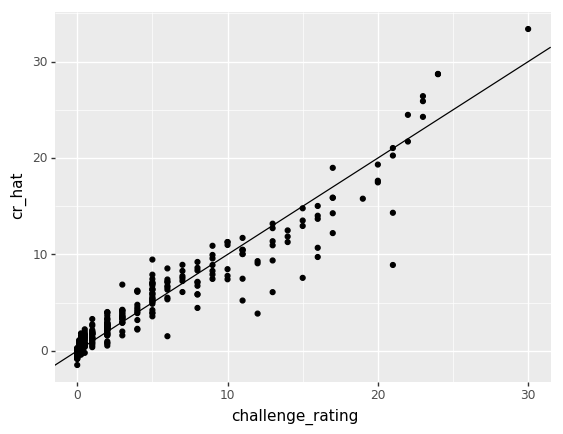

<ggplot: (279171020)>

In [8]:
from plotnine import (aes, geom_abline, geom_point, ggplot)
ggplot(pred, aes(x='challenge_rating', y='cr_hat')) + geom_point() + geom_abline(intercept = 0, slope = 1)

### [todo] What is `lr.score` reporting?

In [9]:
lr.score(X, y)

0.91243233372362997

# Simple neural network

We'll use a single 

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


In [11]:
from sklearn.preprocessing import StandardScaler

# pre-processing
scale_x, scale_y = StandardScaler(),  StandardScaler()
sX = scale_x.fit_transform(X)
sy = scale_y.fit_transform(y)

In [12]:
# A simple example of linear regression.
model = Sequential()
model.add(Dense(1, input_shape=(6,)))
model.compile(loss='mean_squared_error', optimizer=SGD())

In [13]:
# training
# network_history = model.fit(X_train, Y_train, epochs=200, verbose=0, validation_data=(X_val, Y_val))
network_history = model.fit(sX, sy, epochs=20, verbose=0)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


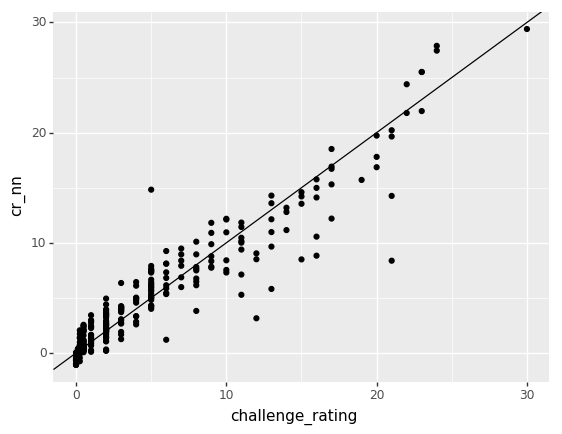

<ggplot: (-9223372036564508142)>

In [15]:
y_hat = scale_y.inverse_transform(model.predict(sX))
pred['cr_nn'] = y_hat

ggplot(pred, aes(x='challenge_rating', y='cr_nn')) + geom_point() + geom_abline(intercept = 0, slope = 1)

The difference in results between linear regression and the neural network are due entirely to the optimization strategies. In the case of sci-kit learn, regression is simply a matter of linear algebra, whereas Keras makes use of gradient descent.

In this particular example, the loss function is convex, and so in the limit (as `epoch` $\to \infty$) the weights converge to the weights of the linear regression.

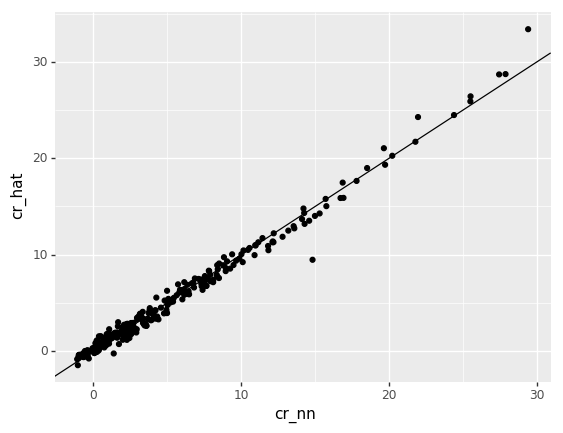

<ggplot: (-9223372036564490538)>

In [16]:
ggplot(pred, aes(x='cr_nn', y='cr_hat')) + geom_point() + geom_abline(intercept = 0, slope = 1)

### [TODO] Add interactive visualization of the above data

# DeepDreaming - or perturbing data for fun and profit
A relatively simple technique, which was describe in this Google research blog [post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) ([source](https://github.com/google/deepdream/blob/master/dream.ipynb)). The example source was later [ported](https://github.com/fchollet/keras/blob/master/examples/deep_dream.py) to Keras.

In the following, we'll adapt this basic idea to our very simple model. Since our model is not scale invariant, working at different octaves isn't helpful.

We'll then generalize to more complicated models.

In [17]:
from keras import backend as K

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [19]:
K.set_learning_phase(0) # 0 = test, 1 = train
layer_dict = {layer.name: layer for layer in model.layers}

dream = model.input # list of input tensors - worth thinking about how to control this?

In [20]:
TARGET = scale_y.transform(5)

# build new loss function
# Add the L2 norm of the features of a layer to the loss.
target = K.constant(TARGET, dtype='float32')

loss = K.variable(0.)
coeff = 1.
x = layer_dict['dense_1'].output - target
scaling = K.prod(K.cast(K.shape(x), 'float32')) # number of entries in x
loss = coeff * K.sum(K.square(x)) / scaling

In [21]:
# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs) # why [dream]?

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_descent(x, iterations, step, max_loss=None):
    # can we use the build in gradient models as well?
    yield x
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            print('Loss value {} is larger then the max_loss'.format(loss_value))
            break
        print('..Loss value at', i, ':', loss_value)
        x -= step * grad_values
        yield x
    return

# build a couple of different ways to access this tool

In [22]:
X.head()

,armor_class,hit_points,has_multiattack,attack_bonus,damage,difficulty_class
name,,,,,,
Aboleth,17,135,1,9,23,14
Acolyte,10,9,0,2,4,10
Adult Black Dragon,19,195,1,11,96,18
Adult Blue Dracolich,19,225,1,12,120,20
Adult Blue Dragon,19,225,1,12,120,19


In [23]:
x = X.loc['Aboleth'].reshape(1, -1)
sx = scale_x.transform(x)

# hyperparameters

step = 0.01  # Gradient ascent step size
iterations = 20  # Number of ascent steps per scale
max_loss = 10. # worth thinking about

# how should I fix parameters? I want to factor through an injective map
# ANSWER: use a matrix multiplication.

# gotta try this!
history = gradient_descent(sx, iterations, step, max_loss)

/Users/jason/Code/cr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/jason/Code/cr/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


..Loss value at 0 : 0.33322
..Loss value at 1 : 0.312306
..Loss value at 2 : 0.292069
..Loss value at 3 : 0.27251
..Loss value at 4 : 0.253629
..Loss value at 5 : 0.235425
..Loss value at 6 : 0.2179
..Loss value at 7 : 0.201052
..Loss value at 8 : 0.184882
..Loss value at 9 : 0.169389
..Loss value at 10 : 0.154575
..Loss value at 11 : 0.140438
..Loss value at 12 : 0.126979
..Loss value at 13 : 0.114198
..Loss value at 14 : 0.102095
..Loss value at 15 : 0.0906697
..Loss value at 16 : 0.0799221
..Loss value at 17 : 0.0698522
..Loss value at 18 : 0.0604602
..Loss value at 19 : 0.0517459


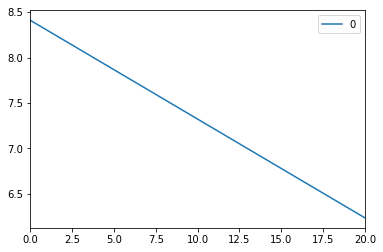

In [24]:
x_vals = list()
y_vals = list()

for x in history:
    x_vals.append(scale_x.inverse_transform(x)[0])
    y = scale_y.inverse_transform(model.predict(x))[0][0]
    y_vals.append(y)
    
% matplotlib inline
pd.DataFrame(y_vals).plot()

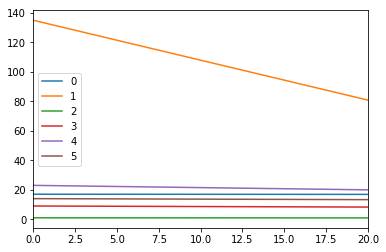

In [25]:
pd.DataFrame(x_vals).plot()

# Generalizing to neural networks with hidden layers

The generalization is quite easy! Just need to build some models.